In [44]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

# --------- Folder Setup ----------
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR      = os.path.join(ROOT, "data")
RAW_DIR       = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
MERGED_DIR    = os.path.join(DATA_DIR, "merged")

for folder in [DATA_DIR, RAW_DIR, PROCESSED_DIR, MERGED_DIR]:
    os.makedirs(folder, exist_ok=True)

# --------- Date Range ----------
START = "2000-01-01"
END = None  # yfinance: None => up to today


In [36]:
def flatten_columns(df):
    """Flatten MultiIndex columns if needed."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(filter(None, map(str, col))).strip() for col in df.columns.values]
    return df

def drop_duplicate_dates(df, date_col):
    # Remove rows with duplicated dates
    df = df.drop_duplicates(subset=[date_col])
    return df

def download_commodity(ticker, name):
    print(f"Downloading {name} ({ticker}) ...")
    df = yf.download(ticker, start=START, end=END, auto_adjust=True)
    if df.empty:
        print(f"Warning: Empty data for {name}")
        return pd.DataFrame()
    df = flatten_columns(df)
    df.reset_index(inplace=True)
    fname = f"{name.lower()}_raw.csv"
    df.to_csv(os.path.join(RAW_DIR, fname), index=False)
    print(f"Saved raw data: {fname}")
    return df

def feature_engineer(df, price_col, name="Commodity"):
    df = df.copy()
    if price_col not in df.columns:
        print(f"{name}: Price col {price_col} not found.")
        return pd.DataFrame()
    df = df.sort_values("Date").reset_index(drop=True)
    df = drop_duplicate_dates(df, "Date")
    df["Return"] = df[price_col].pct_change()
    df["MA_5"] = df[price_col].rolling(5).mean()
    df["Vol_5"] = df["Return"].rolling(5).std()
    out = df.dropna(subset=[price_col, "Return", "MA_5", "Vol_5"]).reset_index(drop=True)
    fname = f"{name.lower()}_processed.csv"
    out.to_csv(os.path.join(PROCESSED_DIR, fname), index=False)
    print(f"Saved processed data: {fname}")
    return out



In [45]:
# ---------- Commodity Tickers & Price Columns ----------
tickers = {
    "Gold":      "GC=F",
    "WTI":       "CL=F",
    "Wheat":     "ZW=F",
    "NaturalGas":"NG=F",
    "Copper":    "HG=F",
    "Lithium":   "LIT"    # ETF proxy; no direct lithium spot price available in yfinance
}
price_cols = {
    "Gold":      "Close_GC=F",
    "WTI":       "Close_CL=F",
    "Wheat":     "Close_ZW=F",
    "NaturalGas":"Close_NG=F",
    "Copper":    "Close_HG=F",
    "Lithium":   "Close_LIT"
}

# ---------- Download, Process, and Merge ----------
dfs_raw, dfs_proc, dfs_merged = {}, {}, {}

for name, ticker in tickers.items():
    df_raw = download_commodity(ticker, name)
    dfs_raw[name] = df_raw
    if not df_raw.empty:
        dfs_proc[name] = feature_engineer(df_raw, price_cols[name], name)
    else:
        dfs_proc[name] = pd.DataFrame()

[*********************100%***********************]  1 of 1 completed


Saved raw data: gold_raw.csv
Saved processed data: gold_processed.csv


[*********************100%***********************]  1 of 1 completed


Saved raw data: wti_raw.csv
Saved processed data: wti_processed.csv


[*********************100%***********************]  1 of 1 completed


Saved raw data: wheat_raw.csv
Saved processed data: wheat_processed.csv


[*********************100%***********************]  1 of 1 completed


Saved raw data: naturalgas_raw.csv
Saved processed data: naturalgas_processed.csv


[*********************100%***********************]  1 of 1 completed


Saved raw data: copper_raw.csv
Saved processed data: copper_processed.csv


[*********************100%***********************]  1 of 1 completed


Saved raw data: lithium_raw.csv
Saved processed data: lithium_processed.csv


In [46]:
def load_gpr(gpr_path):
    if not os.path.exists(gpr_path):
        print(f"GPR dataset not found: {gpr_path}")
        return pd.DataFrame()
    gpr = pd.read_csv(gpr_path)
    if 'DATE' not in gpr.columns:
        print("GPR: missing 'DATE' column")
        return pd.DataFrame()
    gpr['DATE'] = pd.to_datetime(gpr['DATE'], errors='coerce')
    gpr = gpr.dropna(subset=['DATE'])  # Drop missing dates
    gpr = gpr.drop_duplicates(subset=['DATE'])
    gpr = gpr.sort_values('DATE')
    gpr = gpr.reset_index(drop=True)   # Ensure clean index

    gpr_daily = gpr.set_index('DATE').resample('D').ffill().reset_index()
    keep = [col for col in ['DATE', 'GPRD', 'GPRD_THREAT', 'EVENT'] if col in gpr_daily.columns]
    return gpr_daily[keep]


In [47]:
def merge_with_gpr(df, gpr_df, name):
    if df.empty or gpr_df.empty:
        print(f"Skipping merge for {name}: Empty dataframe(s).")
        return pd.DataFrame()
    df = drop_duplicate_dates(df, "Date")
    merged = pd.merge(df, gpr_df, left_on="Date", right_on="DATE", how="left")
    fname = f"{name.lower()}_merged.csv"
    merged.to_csv(os.path.join(MERGED_DIR, fname), index=False)
    print(f"Saved merged data: {fname}")
    return merged

# Adapt GPR path as in your structure
gpr_path = os.path.join(RAW_DIR, "All_Historical_Data_Separately", "Geopolitical Risk Index Daily.csv")
gpr_daily = load_gpr(gpr_path)
dfs_merged = {}
for name, df_proc in dfs_proc.items():
    dfs_merged[name] = merge_with_gpr(df_proc, gpr_daily, name)

# ---------- Check Outputs ----------
for name, df_merged in dfs_merged.items():
    if not df_merged.empty:
        print(f"\n{name} merged preview:")
        print(df_merged.head())

Saved merged data: gold_merged.csv
Saved merged data: wti_merged.csv
Saved merged data: wheat_merged.csv
Saved merged data: naturalgas_merged.csv
Saved merged data: copper_merged.csv
Saved merged data: lithium_merged.csv

Gold merged preview:
        Date  Close_GC=F   High_GC=F    Low_GC=F   Open_GC=F  Volume_GC=F  \
0 2000-09-07  274.000000  274.000000  274.000000  274.000000          125   
1 2000-09-08  273.299988  273.299988  273.299988  273.299988            0   
2 2000-09-11  273.100006  273.100006  273.100006  273.100006            0   
3 2000-09-12  272.899994  272.899994  272.899994  272.899994            0   
4 2000-09-13  272.799988  272.799988  272.799988  272.799988            0   

     Return        MA_5     Vol_5       DATE   GPRD  GPRD_THREAT EVENT  
0 -0.000729  275.859998  0.009121 2000-09-07  47.72        66.13   NaN  
1 -0.002555  274.859998  0.001991 2000-09-08  59.21        36.28   NaN  
2 -0.000732  274.079999  0.002235 2000-09-11  44.27        36.81   NaN  
3 

In [40]:
for name, df_merged in dfs_merged.items():
    if not df_merged.empty:
        print(f"\n{name} merged preview:")
        print(df_merged.head())



Gold merged preview:
        Date  Close_GC=F   High_GC=F    Low_GC=F   Open_GC=F  Volume_GC=F  \
0 2000-09-07  274.000000  274.000000  274.000000  274.000000          125   
1 2000-09-08  273.299988  273.299988  273.299988  273.299988            0   
2 2000-09-11  273.100006  273.100006  273.100006  273.100006            0   
3 2000-09-12  272.899994  272.899994  272.899994  272.899994            0   
4 2000-09-13  272.799988  272.799988  272.799988  272.799988            0   

     Return        MA_5     Vol_5       DATE   GPRD  GPRD_THREAT EVENT  
0 -0.000729  275.859998  0.009121 2000-09-07  47.72        66.13   NaN  
1 -0.002555  274.859998  0.001991 2000-09-08  59.21        36.28   NaN  
2 -0.000732  274.079999  0.002235 2000-09-11  44.27        36.81   NaN  
3 -0.000732  273.500000  0.002209 2000-09-12  30.50        15.22   NaN  
4 -0.000366  273.219995  0.000871 2000-09-13  30.50        15.22   NaN  

WTI merged preview:
        Date  Close_CL=F  High_CL=F   Low_CL=F  Open_CL=

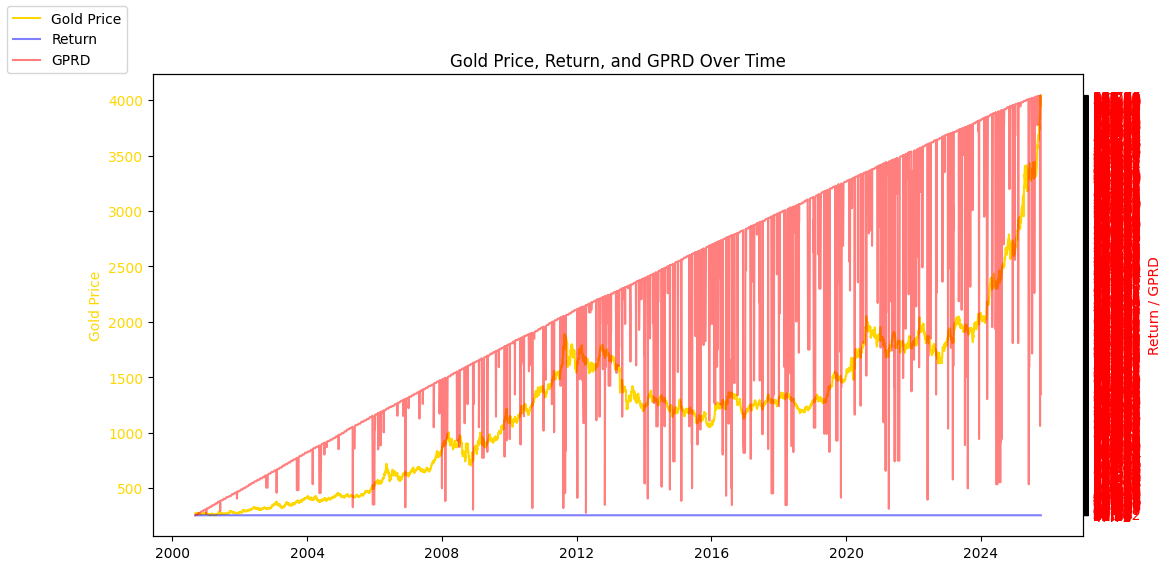

In [30]:
import matplotlib.pyplot as plt

# Example for Gold
df = dfs_merged['Gold']

# Set Date as index for plotting
df = df.set_index('Date')

# Plot price, return, and GPRD on the same chart (with secondary y-axis if needed)
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df.index, df['Close_GC=F'], label='Gold Price', color='gold')
ax1.set_ylabel('Gold Price', color='gold')
ax1.tick_params(axis='y', labelcolor='gold')

ax2 = ax1.twinx()
ax2.plot(df.index, df['Return'], label='Return', color='blue', alpha=0.5)
ax2.plot(df.index, df['GPRD'], label='GPRD', color='red', alpha=0.5)
ax2.set_ylabel('Return / GPRD', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend(loc='upper left')
plt.title('Gold Price, Return, and GPRD Over Time')
plt.show()

Gold price and GPRD correlation: -0.076


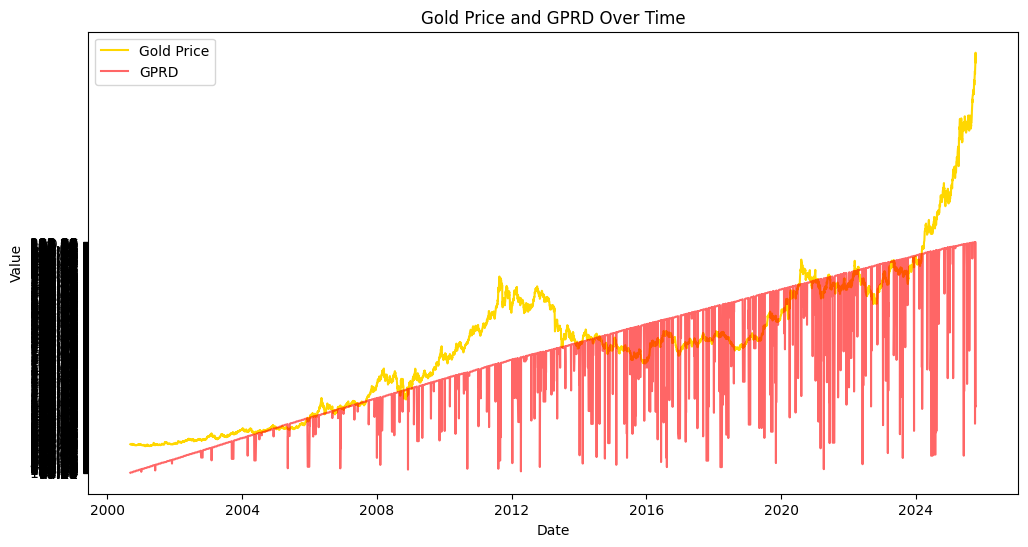

In [33]:
import matplotlib.pyplot as plt

# --- Correlation ---
df_gold = dfs_merged['Gold'].dropna(subset=['Close_GC=F', 'GPRD'])
corr_gold = df_gold['Close_GC=F'].corr(df_gold['GPRD'])
print(f"Gold price and GPRD correlation: {corr_gold:.3f}")

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_gold['Date'], df_gold['Close_GC=F'], label='Gold Price', color='gold')
plt.plot(df_gold['Date'], df_gold['GPRD'], label='GPRD', color='red', alpha=0.6)
plt.legend()
plt.title('Gold Price and GPRD Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


WTI price and GPRD correlation: -0.248


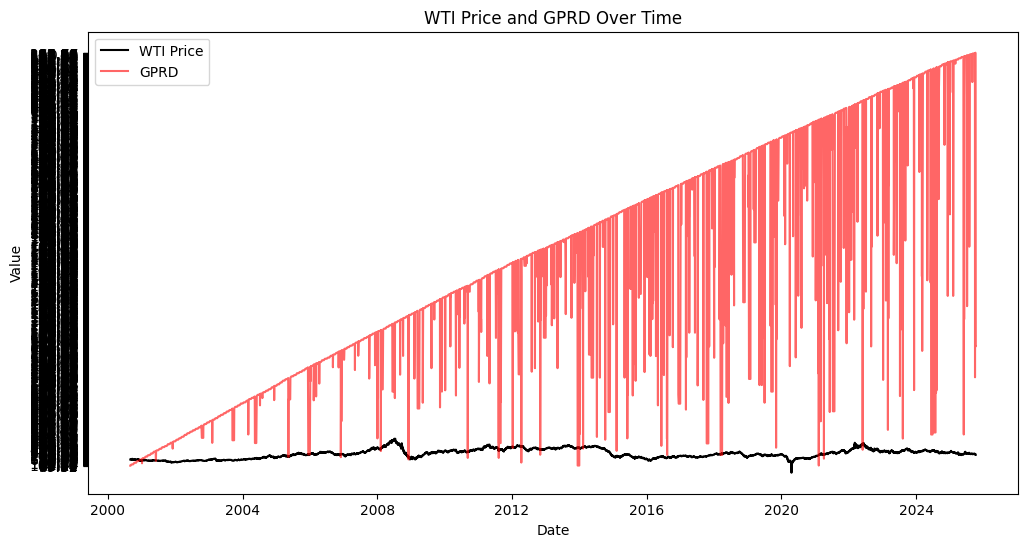

In [31]:
# --- Correlation ---
df_wti = dfs_merged['WTI'].dropna(subset=['Close_CL=F', 'GPRD'])
corr_wti = df_wti['Close_CL=F'].corr(df_wti['GPRD'])
print(f"WTI price and GPRD correlation: {corr_wti:.3f}")

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_wti['Date'], df_wti['Close_CL=F'], label='WTI Price', color='black')
plt.plot(df_wti['Date'], df_wti['GPRD'], label='GPRD', color='red', alpha=0.6)
plt.legend()
plt.title('WTI Price and GPRD Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


Wheat price and GPRD correlation: -0.168


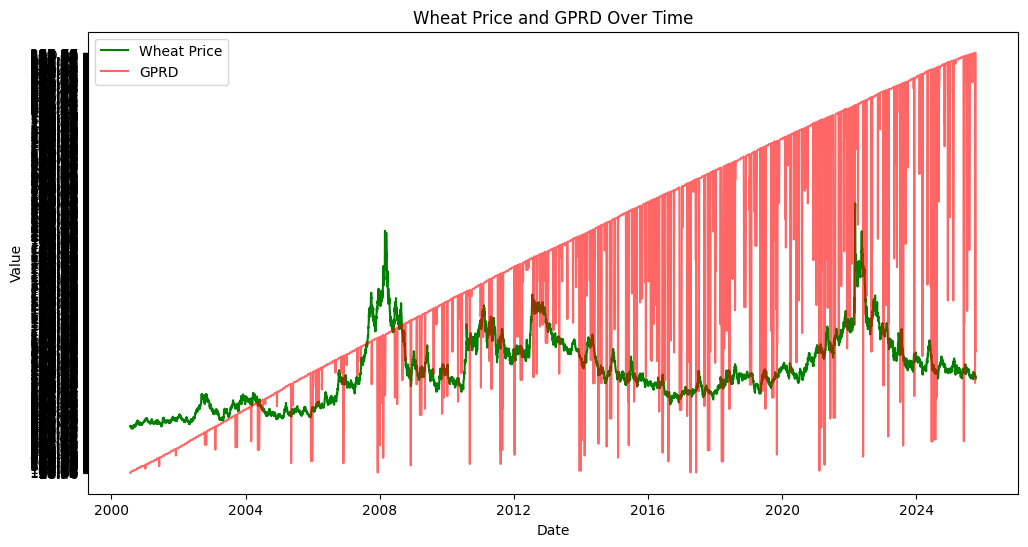

In [32]:
# --- Correlation ---
df_wheat = dfs_merged['Wheat'].dropna(subset=['Close_ZW=F', 'GPRD'])
corr_wheat = df_wheat['Close_ZW=F'].corr(df_wheat['GPRD'])
print(f"Wheat price and GPRD correlation: {corr_wheat:.3f}")

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_wheat['Date'], df_wheat['Close_ZW=F'], label='Wheat Price', color='green')
plt.plot(df_wheat['Date'], df_wheat['GPRD'], label='GPRD', color='red', alpha=0.6)
plt.legend()
plt.title('Wheat Price and GPRD Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


# Natural Gas (Log scale)

Natural Gas price and GPRD correlation: -0.027


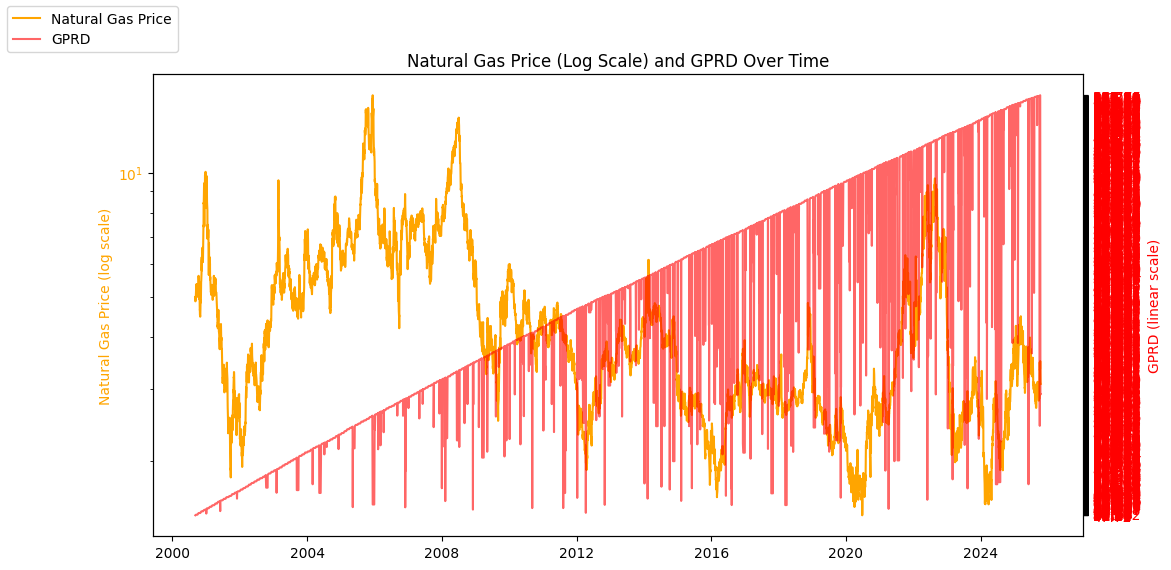

In [51]:
import matplotlib.pyplot as plt

df_ng = dfs_merged['NaturalGas'].dropna(subset=['Close_NG=F', 'GPRD'])
corr_ng = df_ng['Close_NG=F'].corr(df_ng['GPRD'])
print(f"Natural Gas price and GPRD correlation: {corr_ng:.3f}")

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_ng['Date'], df_ng['Close_NG=F'], label='Natural Gas Price', color='orange')
ax1.set_ylabel('Natural Gas Price (log scale)', color='orange')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(df_ng['Date'], df_ng['GPRD'], label='GPRD', color='red', alpha=0.6)
ax2.set_ylabel('GPRD (linear scale)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend(loc='upper left')
plt.title('Natural Gas Price (Log Scale) and GPRD Over Time')
plt.xlabel('Date')
plt.show()


# Copper

Copper price and GPRD correlation: -0.187


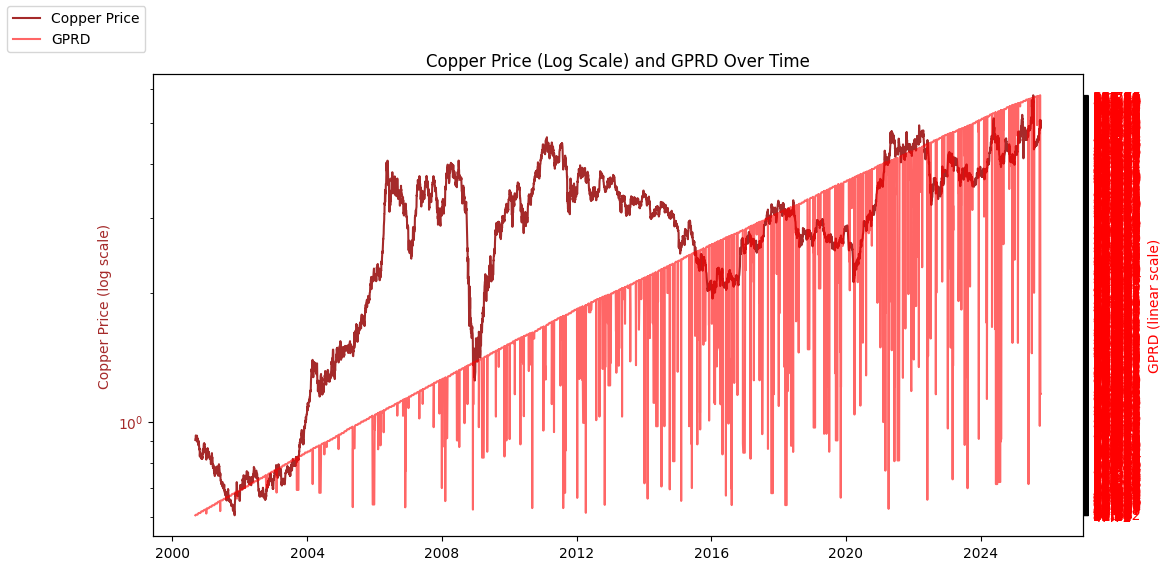

In [52]:
df_copper = dfs_merged['Copper'].dropna(subset=['Close_HG=F', 'GPRD'])
corr_copper = df_copper['Close_HG=F'].corr(df_copper['GPRD'])
print(f"Copper price and GPRD correlation: {corr_copper:.3f}")

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_copper['Date'], df_copper['Close_HG=F'], label='Copper Price', color='brown')
ax1.set_ylabel('Copper Price (log scale)', color='brown')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='brown')

ax2 = ax1.twinx()
ax2.plot(df_copper['Date'], df_copper['GPRD'], label='GPRD', color='red', alpha=0.6)
ax2.set_ylabel('GPRD (linear scale)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend(loc='upper left')
plt.title('Copper Price (Log Scale) and GPRD Over Time')
plt.xlabel('Date')
plt.show()


# Lithium (LIT ETF Proxy)


Lithium ETF (LIT) and GPRD correlation: 0.218


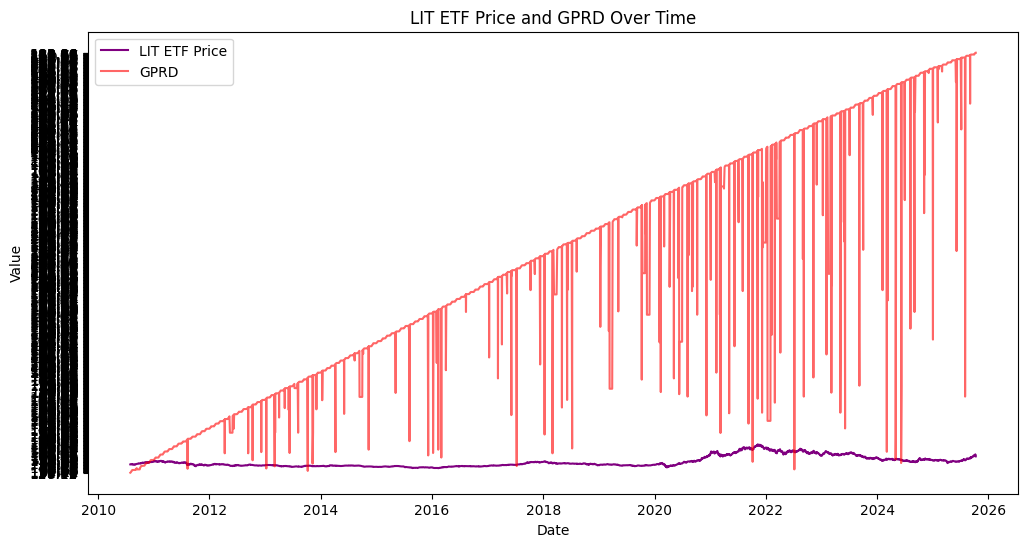

In [53]:
df_lithium = dfs_merged['Lithium'].dropna(subset=['Close_LIT', 'GPRD'])
corr_lithium = df_lithium['Close_LIT'].corr(df_lithium['GPRD'])
print(f"Lithium ETF (LIT) and GPRD correlation: {corr_lithium:.3f}")

plt.figure(figsize=(12,6))
plt.plot(df_lithium['Date'], df_lithium['Close_LIT'], label='LIT ETF Price', color='purple')
plt.plot(df_lithium['Date'], df_lithium['GPRD'], label='GPRD', color='red', alpha=0.6)
plt.legend()
plt.title('LIT ETF Price and GPRD Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
